In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sportran as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [214]:
from scipy.interpolate import CubicSpline, interp1d
def model_scalar(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

n = 2
def model_wishart_(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [np.zeros_like(y01), y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    # return interp1d(xx, yy)) 
    return CubicSpline(xx, yy) #, bc_type = 'clamped')

import numpy as np
from scipy.interpolate import CubicSpline

def model_wishart(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    upper_triangle_indices = np.triu_indices(N)
    y_elements = y.reshape(len(upper_triangle_indices[0]), l)
    
    yy = np.zeros((l, N, N))
    for k, (i, j) in enumerate(zip(*upper_triangle_indices)):
        yy[:, j, i] = y_elements[k]
    
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)


In [52]:
dc=np.load('data/bayesian/CsF/dc_minimal.npy', allow_pickle = True).item()

In [274]:
flux = st.HeatCurrent([
    dc['qflux'],
    dc['ele_flux']
    ],
                       DT_FS=1,
                       TEMPERATURE=dc['Temeprature'],
                       VOLUME=dc['Volume'],
                       UNITS='metal')

Using multicomponent code.


In [275]:
flux_resample=flux.resample(fstar_THz=20)

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =        100001
 Resampled n. of frequencies =          4001
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00018
 % of original PSD Power f<f* (pre-filter&sample)  = 99.707 %
 fPSD not calculated before resampling
 -----------------------------------------------------



In [278]:
flux_resample.maxlike_estimate(lambda x, y: model_wishart(x, y, 2), 12)

MaxLikeFilter
Maximum-likelihood estimate with 12 parameters
Spline nodes are equispaced from 0 to the Nyquist frequency.
The BFGS solver features the calculation of the Hessian. The covariance matrix will be estimated through the Laplace approximation.


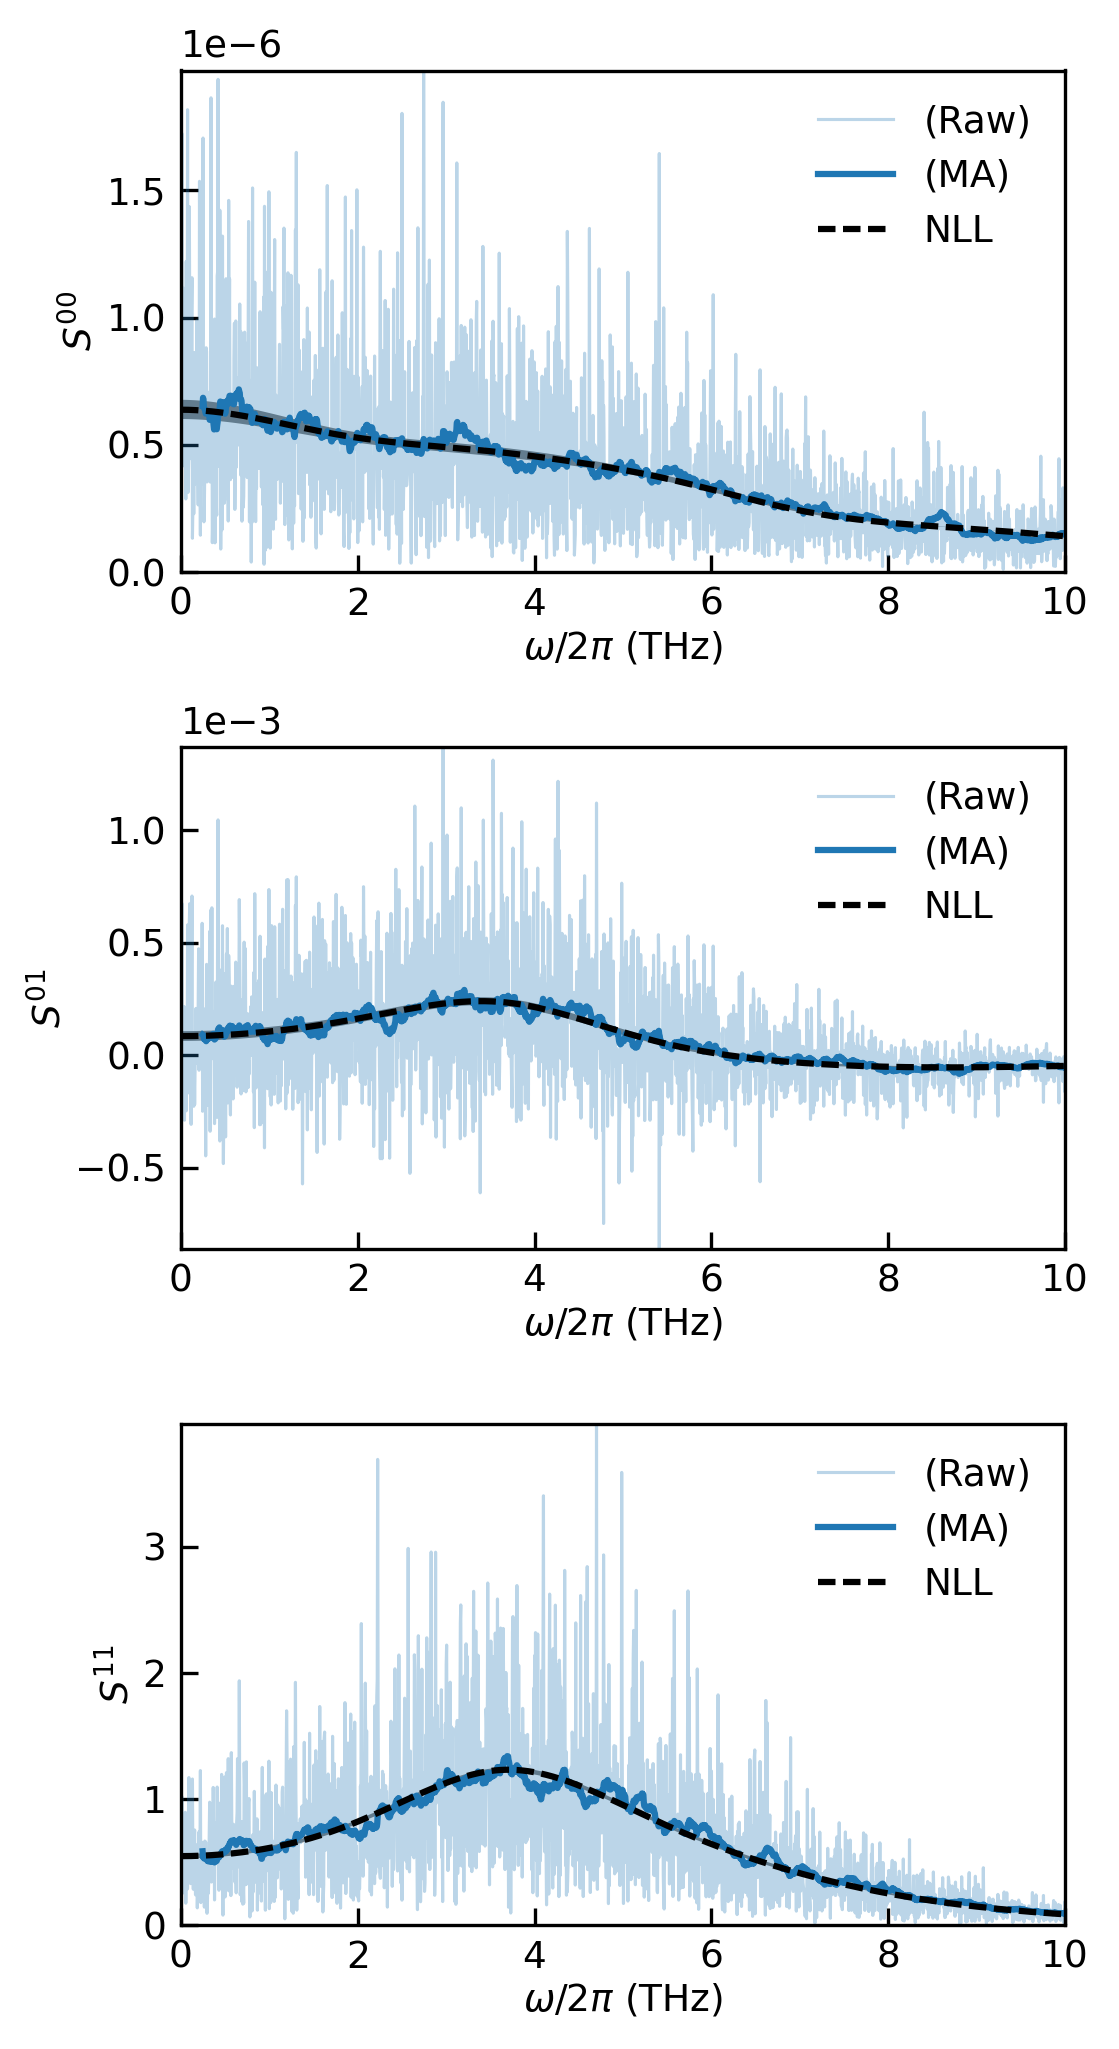

In [315]:
omega = flux_resample.maxlike.omega
data_wishart = flux_resample.maxlike.data
estimate = flux_resample.NLL_spline(omega)
estimate_p = flux_resample.NLL_spline_upper(omega)
estimate_m = flux_resample.NLL_spline_lower(omega)

ip = 0
addaxes = []

N = data_wishart.shape[-1]
fs = plt.rcParams['figure.figsize']

fig, axes = plt.subplots(nrows = N*(N+1)//2, ncols = 1, figsize = (fs[0], 3*fs[1]))

for ax, i, j in zip(axes, *np.triu_indices(2)):

        pl, = ax.plot(flux_resample.freqs_THz, 
                        data_wishart[:, i, j]*flux_resample.KAPPA_SCALE/2, 
                        alpha = 0.3, 
                        label = f'(Raw)',
                )

        ax.plot(flux_resample.freqs_THz, 
                pd.Series(data_wishart[:, i, j]).rolling(window=50).mean()*flux_resample.KAPPA_SCALE/2, 
                alpha = 1, 
                label = f'(MA)', 
                lw = 1.5,
                color = pl.get_color()
                )

        x, y = flux_resample.freqs_THz, estimate[:, i, j]*flux_resample.KAPPA_SCALE/2
        ym, yp = estimate_m[:, i, j]*flux_resample.KAPPA_SCALE/2, estimate_p[:, i, j]*flux_resample.KAPPA_SCALE/2

        ax.plot(x, 
                y, 
                color = 'k',
                lw = 1.5,
                label = 'NLL',
                ls = '--')
                
        ax.fill_between(x, 
                        ym, 
                        yp, 
                        color = 'k', 
                        alpha = 0.5)
                
        ax.set_xlim(0,10)
        ax.set_ylim(0 if i == j else None)
        
        ax.set_xlabel('$\omega/2\pi$ (THz)')
        ax.set_ylabel(f'$S^{{{i}{j}}}$')

        ax.legend()

fig.tight_layout()